* 按照 baseline 的方式, 直接读取已预处理过后的文件, 进行模型的训练
* 现在需要将图片和 Label 读入内存
    * 预先切分训练/验证集
    * 分别进行存储
* 训练 2 个 epoch
    * 第一个 epoch 的 lr = 0.001
    * 第二个 epoch 的 lr = 0.00002
* 先不对验证集进行预处理, 测试这样预处理效果如何
* 再对验证集进行预处理, 得到每张图片 8 个不同的预测结果, 在做加权平均, 作为该图片的真实预测结果

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import itertools

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 导入数据

In [2]:
import os

def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))

mkdir_if_not_exist(['data-raw/preprocessing/Images'])

In [3]:
df_train = pd.read_csv('data-raw/train_2/Annotations/label_5.csv')
#df_train.columns = ['image_id', 'class', 'label']
df_train.head()

,image_id,class,label,human
0,Images/collar_design_labels/b23a3fe060d71bed77...,collar_design_labels,ynnnn,0
1,Images/collar_design_labels/0ef580b4deabcd9fa4...,collar_design_labels,ynnnn,0
2,Images/collar_design_labels/87ccc33937821a97ad...,collar_design_labels,nnynn,0
3,Images/collar_design_labels/26caac7d1f1b36fb9d...,collar_design_labels,ynnnn,0
4,Images/collar_design_labels/396ab4e7cbc6798100...,collar_design_labels,nynnn,0


In [4]:
classes = ['collar_design_labels', 'neckline_design_labels', 'skirt_length_labels',
          'sleeve_length_labels', 'neck_design_labels', 'coat_length_labels', 'lapel_design_labels',
          'pant_length_labels']

## 加载数据

In [5]:
cur_class = classes[5]
df_load = df_train[(df_train['class'] == cur_class)].copy()
df_load.reset_index(inplace=True)
del df_load['index']

print('{0}: {1}'.format(cur_class, len(df_load)))
df_load.head()

coat_length_labels: 14454


,image_id,class,label,human
0,Images/coat_length_labels/55eb58f477d33272aff3...,coat_length_labels,nnynnnnn,1
1,Images/coat_length_labels/6324fc9b689445b9dbc5...,coat_length_labels,nnynnnnn,1
2,Images/coat_length_labels/c82f855a3115f6ec5520...,coat_length_labels,nnnnnynn,0
3,Images/coat_length_labels/a9b54e901758ee46c63a...,coat_length_labels,nnnnynnn,1
4,Images/coat_length_labels/bf4ac23424dbed2abc17...,coat_length_labels,nnnnnnny,1


In [6]:
mkdir_if_not_exist(['data-raw/preprocessing/Images/{}'.format(cur_class)])

In [7]:
n_ration=0.9
df_valid=df_load[int(n_ration*len(df_load)):]

df_load=df_load[:int(n_ration*len(df_load))]

In [8]:
n = len(df_load)
n_class = len(df_load['label'][0])
width = 299 # 定义图片大小



## 数据预处理

In [9]:
from PIL import Image
import os
import os.path
from skimage import data, img_as_float
from skimage import exposure
import shutil

In [10]:
rootdir ='data-raw/train_2/'  # 指明被遍历的文件夹
m = 0
outdir ='data-raw/preprocessing/'

## 加载训练集

In [13]:
#变换的样式
#{0:"299X299",1:"顺时针30度",2:"逆时针30度",3:"高斯噪声",4:"直方图",5:"对比拉伸",6:"水平翻转",7:"水平翻转+高斯噪声",8:"水平翻转+直方图"}
trans_style_1=[0,8]
n_times_1=len(trans_style_1)
X_train_1 = np.zeros((n*n_times_1, width, width, 3), dtype=np.uint8)
y_train = np.zeros((n*n_times_1, n_class), dtype=np.uint8)


In [14]:
trans_style_2=[6,5]
n_times_2=len(trans_style_2)
X_train_2 = np.zeros((n*n_times_2, width, width, 3), dtype=np.uint8)
#y_train_main = np.zeros((n*n_times, n_class), dtype=np.uint8)

In [16]:
for i in tqdm(range(n)):
    tmp_label = df_load['label'][i]
    #human=int(df_load['human'][i])
    for j in range(len(trans_style_1)):
        X_train_1[i*n_times_1+j] = cv2.resize(cv2.imread(outdir + df_load['image_id'][i] + "-%s.jpg"%trans_style_1[j]), (width, width))
        X_train_2[i*n_times_2+j] = cv2.resize(cv2.imread(outdir + df_load['image_id'][i] + "-%s.jpg"%trans_style_2[j]), (width, width))
        y_train[i*n_times_1+j][tmp_label.find('y')] = 1
       # y_train_auxi[i*n_times+j][0] = human

100%|██████████| 13008/13008 [01:27<00:00, 148.46it/s]


In [ ]:
# for i in tqdm(range(n)):
#    # tmp_label = df_load['label'][i]
#     #human=int(df_load['human'][i])
#     for j in range(len(trans_style)):
#         X_train_2[i*n_times+j] = cv2.resize(cv2.imread(outdir + df_load['image_id'][i] + "-%s.jpg"%trans_style_2[j]), (width, width))
#         #y_train[i*n_times+j][tmp_label.find('y')] = 1

## 加载验证集

In [17]:
df_valid.reset_index(inplace=True)
del df_valid['index']
n_valid=len(df_valid)
X_valid = np.zeros((n_valid, width, width, 3), dtype=np.uint8)
y_valid = np.zeros((n_valid, n_class), dtype=np.uint8)

for i in tqdm(range(n_valid)):
    tmp_label = df_valid['label'][i]
    img=cv2.imread('data-raw/train_2/{0}'.format(df_valid['image_id'][i])) 
    row, column, channels = img.shape
    max_value = max(row, column)
    pad_img= cv2.copyMakeBorder(img,(max_value-row)//2,(max_value-row)//2,(max_value-column)//2,(max_value-column)//2,cv2.BORDER_CONSTANT)
    X_valid[i] = cv2.resize(pad_img, (299, 299), interpolation=cv2.INTER_AREA)
    y_valid[i][tmp_label.find('y')] = 1
    #y_valid_auxi[i][0]=int(df_valid['human'][i])

100%|██████████| 1446/1446 [00:11<00:00, 121.24it/s]


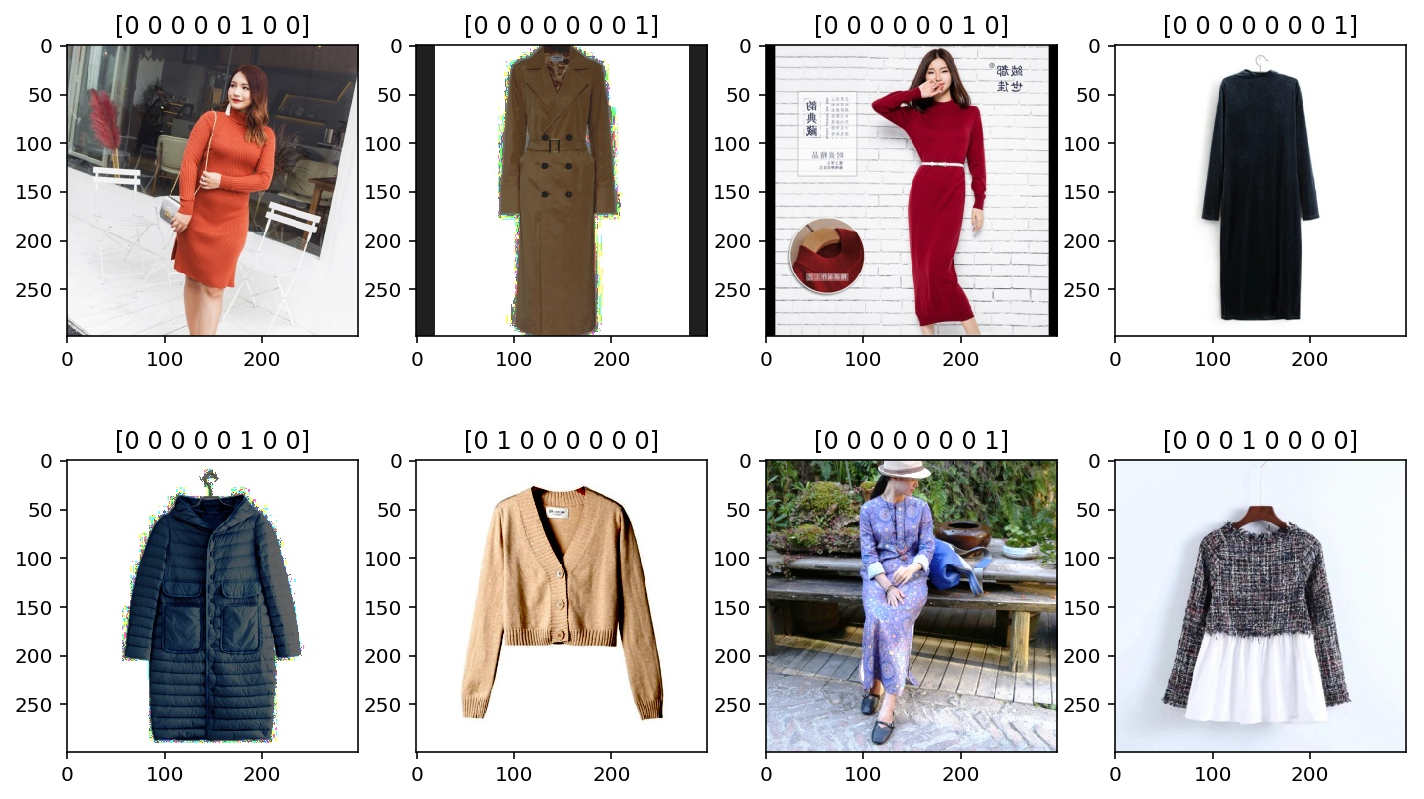

In [17]:
# 随机显示 8 张图片
plt.figure(figsize=(12, 7))
for i in range(8):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(X_train[random_index][:,:,::-1])
    plt.title(y_train[random_index])

## 建立模型

In [18]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras.optimizers import *
from keras.applications import *
from keras.regularizers import *
from keras.applications.inception_resnet_v2 import preprocess_input
#from keras.applications.densenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import RMSprop
import keras

Using TensorFlow backend.


In [19]:
cnn_model = InceptionResNetV2(include_top=False, input_shape=(width, width, 3), weights='imagenet')


cnn_model_2 = Xception(include_top=False, input_shape=(width, width, 3), weights='imagenet')


inputs_1 = Input((width, width, 3))
x1 = inputs_1
x1 = Lambda(preprocess_input, name='preprocessing1')(x1)
x1 = cnn_model(x1)
#x1 = GlobalAveragePooling2D()(x1)
#x1 = Dropout(0.5)(x1) 
#x1 = Dense(n_class, activation='softmax', name='softmax1')(x1)



inputs_2 = Input((width, width, 3))
x2 = inputs_2
x2 = Lambda(preprocess_input, name='preprocessing2')(x2)
x2 = cnn_model_2(x2)
x2 = Conv2D(2560, (3, 3))(x2)
#x2 = GlobalAveragePooling2D()(x2)
#x2 = Dropout(0.5)(x2) 
#x2 = Dense(n_class, activation='softmax', name='softmax2')(x2)
#model = Model(inputs, x)

x3=Concatenate()([x1,x2])
x3=GlobalAveragePooling2D()(x3)
x3=Dense(512, activation='relu', name='dense_1')(x3)
x3=Dropout(0.5)(x3)

x3 = Dense(n_class, activation='softmax', name='softmax')(x3)

#x_all=Average()([x1,x2])#1、在哪一层结合，2、用什么算法结合，3、以及input输入部分都可以尝试

model = Model(inputs=[inputs_1,inputs_2],outputs=x3)

In [20]:
adam = Adam(lr=0.001)
prefix_cls = cur_class.split('_')[0]

In [21]:
adam = Adam(lr=1e-3)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
epochs = 3
batch_size = 16

In [27]:
save_path='models/{0}_multi_inputs_augment.best0529_Inception.h5'.format(prefix_cls)
load_path='models/{0}_multi_inputs_augment.best0529_Inception.h5'.format(prefix_cls)

In [31]:
checkpointer = ModelCheckpoint(filepath=save_path, verbose=1, 
                               save_best_only=True,save_weights_only=True)

h = model.fit([X_train_1,X_train_2], y_train, batch_size=batch_size, epochs=epochs, 
              callbacks=[EarlyStopping(patience=3), checkpointer], 
              shuffle=True, 
              validation_data=([X_valid,X_valid_filp], y_valid))

Train on 26016 samples, validate on 1446 samples
Epoch 1/3
26016/26016 [==============================] - 1557s 60ms/step - loss: 1.5664 - acc: 0.3665 - val_loss: 1.3637 - val_acc: 0.4613

Epoch 00001: val_loss improved from inf to 1.36366, saving model to models/coat_multi_inputs_augment.best0529_Inception.h5
Epoch 2/3
26016/26016 [==============================] - 1531s 59ms/step - loss: 1.3291 - acc: 0.4726 - val_loss: 1.1750 - val_acc: 0.5152

Epoch 00002: val_loss improved from 1.36366 to 1.17496, saving model to models/coat_multi_inputs_augment.best0529_Inception.h5
Epoch 3/3
26016/26016 [==============================] - 1531s 59ms/step - loss: 1.1774 - acc: 0.5316 - val_loss: 1.0986 - val_acc: 0.5602

Epoch 00003: val_loss improved from 1.17496 to 1.09857, saving model to models/coat_multi_inputs_augment.best0529_Inception.h5


In [24]:
# 学习率减小 10 倍
adam = Adam(lr=0.0001)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
save_path='models/{0}2_multi_inputs_augment.best0529_Inception.h5'.format(prefix_cls)
load_path='models/{0}_multi_inputs_augment.best0529_Inception.h5'.format(prefix_cls)

In [26]:
checkpointer = ModelCheckpoint(filepath=save_path, verbose=1, 
                               save_best_only=True,save_weights_only=True)
model.load_weights(load_path)
try:
    h = model.fit([X_train_1,X_train_2], y_train, batch_size=batch_size, epochs=epochs, 
              callbacks=[EarlyStopping(patience=3), checkpointer], 
              shuffle=True, 
              validation_data=([X_valid,X_valid_filp], y_valid))
except KeyboardInterrupt:
    print('KeyboardInterrupt')

Train on 52032 samples, validate on 1446 samples
Epoch 1/3
52032/52032 [==============================] - 1255s 24ms/step - loss: 0.5514 - softmax_loss: 0.5450 - sigmoid_loss: 0.0324 - softmax_acc: 0.7788 - sigmoid_acc: 0.9922 - val_loss: 1.0471 - val_softmax_loss: 1.0350 - val_sigmoid_loss: 0.0604 - val_softmax_acc: 0.6549 - val_sigmoid_acc: 0.9855

Epoch 00001: val_loss improved from inf to 1.04707, saving model to models/coat2_multi_outputs_augment.best0529_Inception.h5
Epoch 2/3
52032/52032 [==============================] - 1200s 23ms/step - loss: 0.2480 - softmax_loss: 0.2422 - sigmoid_loss: 0.0293 - softmax_acc: 0.9035 - sigmoid_acc: 0.9931 - val_loss: 1.3939 - val_softmax_loss: 1.3825 - val_sigmoid_loss: 0.0566 - val_softmax_acc: 0.6245 - val_sigmoid_acc: 0.9896

Epoch 00002: val_loss did not improve from 1.04707
Epoch 3/3
52032/52032 [==============================] - 1201s 23ms/step - loss: 0.1139 - softmax_loss: 0.1093 - sigmoid_loss: 0.0229 - softmax_acc: 0.9588 - sigmoid_a

In [29]:
#验证集与测试集变换
def his_trans(n,x): #直方图
    X_new=np.zeros_like(x)
    for i in range(n):
        X_new[i]= exposure.equalize_hist(x[i])*255 
    return X_new

def flip_trans(n,x):#水平翻转
    X_new=np.zeros_like(x)
    for i in range(n):
        X_new[i]= cv2.flip(x[i], 1) 
    return X_new

def gauss_noise(n,x):#高斯噪声
    Gauss_noise = np.random.normal(0, 20, (299, 299, 3))
    X_new=np.zeros_like(x)
    for i in range(n):
        X_new[i]= x[i] + Gauss_noise
        X_new[i]= np.where(X_new[i] < 0, 0, np.where(X_new[i] > 255, 255, X_new[i]))
    return X_new

def contrast_trans(n,x):#对比拉伸
    X_new=np.zeros_like(x)
    for i in range(n):
        p2, p98 = np.percentile(x[i], (2, 98))
        X_new[i] = exposure.rescale_intensity(x[i], in_range=(p2, p98)) 
    return X_new

def rotation_trans(n,x,degree=30):#旋转
    X_new=np.zeros_like(x)
    M1 = cv2.getRotationMatrix2D((299/2,299/2),degree,1) 
    for i in range(n):
        X_new[i] = cv2.warpAffine(x[i],M1,(299,299))
    return X_new

In [30]:
X_valid_filp=flip_trans(n_valid,X_valid)
X_valid_flip_his=his_trans(n_valid,X_valid_filp)
X_valid_contrast=contrast_trans(n_valid,X_valid)

In [29]:
model.load_weights(save_path)

In [31]:
model.evaluate(X_valid,[y_valid_main,y_valid_auxi])

1446/1446 [==============================] - 12s 8ms/step


[1.047066832808868,
 1.0349952135837919,
 0.060358088063578515,
 0.6549100968188105,
 0.9854771784232366]

In [32]:
model.evaluate(X_valid_filp,[y_valid_main,y_valid_auxi])

1446/1446 [==============================] - 12s 8ms/step


[1.074421135221774,
 1.062461376025304,
 0.05979880686517017,
 0.6424619641211683,
 0.9854771784232366]

In [33]:
model.evaluate(X_valid_flip_his,[y_valid_main,y_valid_auxi])

1446/1446 [==============================] - 12s 8ms/step


[1.0840898092686717,
 1.0710942773238588,
 0.06497764722213863,
 0.6376210235955804,
 0.9847856154910097]

In [34]:
model.evaluate(X_valid_contrast,[y_valid_main,y_valid_auxi])

1446/1446 [==============================] - 12s 8ms/step


[1.0446339403775058,
 1.0326317862026588,
 0.06001073655063405,
 0.6549100968188105,
 0.9847856154910097]

In [35]:
valid_np_padding = model.predict(X_valid)
valid_np_filp = model.predict(X_valid_filp)
valid_np_flip_his = model.predict(X_valid_flip_his)
valid_np_contrast = model.predict(X_valid_contrast)

In [36]:
valid_np=(valid_np_padding[0]+valid_np_filp[0]+valid_np_flip_his[0]+valid_np_contrast[0])/4

In [37]:
#计算tta准确率
#Y_pred =  valid_np[:,:-1]
#y_valid = y_valid[:,:-1]
y_pred=np.argmax(valid_np,axis=1)
y_true=np.argmax(y_valid_main,axis=1)
m=y_pred-y_true
s=0
for i in range(len(m)):
    if m[i]==0:s +=1
print(s/len(m))

0.6535269709543569


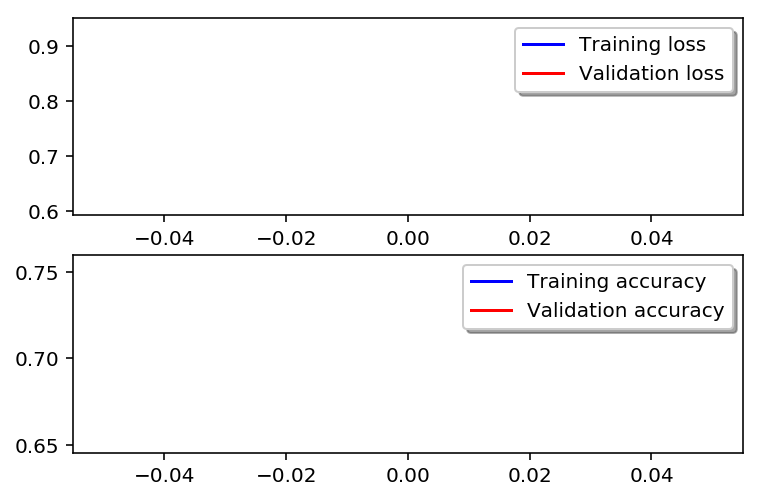

In [26]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2, 1)
ax[0].plot(h.history['loss'], color='b', label="Training loss")
ax[0].plot(h.history['val_loss'], color='r', label="Validation loss", axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(h.history['acc'], color='b', label="Training accuracy")
ax[1].plot(h.history['val_acc'], color='r', label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

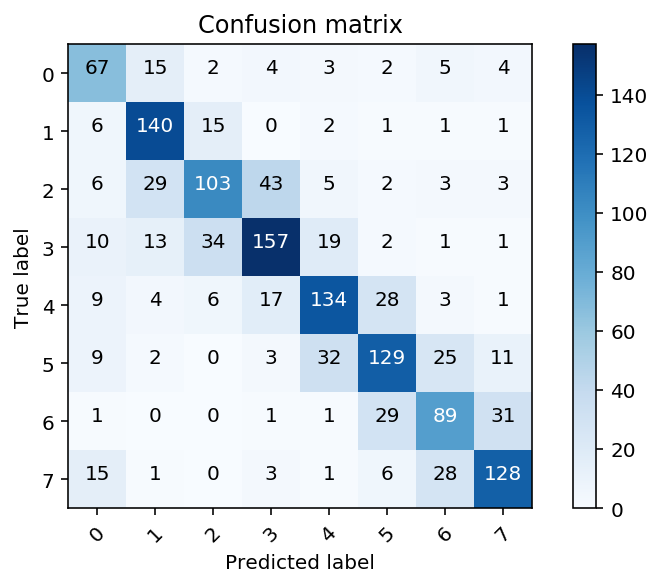

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This fuction prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Predict the values from the validation dataset
Y_pred = model.predict(X_valid)

Y_pred =  Y_pred[0]
y_valid = y_valid_main

# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_valid, axis=1)
# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plt the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(n_class))

In [30]:
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_valid[errors]



In [31]:
def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row, col].imshow((img_errors[error]).reshape((299, 299, 3)))
            ax[row, col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error], obs_errors[error]))
            n += 1

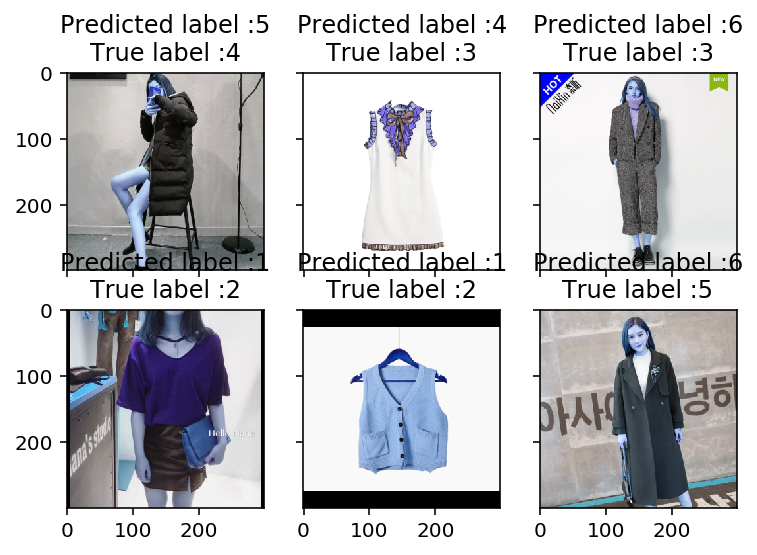

In [32]:
# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors, axis=1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors
most_imaportant_errors = sorted_dela_errors[-12:]

# Show the top 6 errors
display_errors(most_imaportant_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

## 预测结果

In [44]:
df_test = pd.read_csv('data-raw/week-rank/Tests/question.csv', header=None)
df_test.columns = ['image_id', 'class', 'x']
del df_test['x']
df_test.head()

,image_id,class
0,Images/collar_design_labels/1078bc9a4fa91aef69...,collar_design_labels
1,Images/collar_design_labels/272c5d069581efc94f...,collar_design_labels
2,Images/collar_design_labels/2e67922d82216cc756...,collar_design_labels
3,Images/collar_design_labels/d9726ceee17c7ee811...,collar_design_labels
4,Images/collar_design_labels/1b7de7f9def99a5aa6...,collar_design_labels


In [45]:
df_load = df_test[(df_test['class'] == cur_class)].copy()
df_load.reset_index(inplace=True)
del df_load['index']

print('{0}: {1}'.format(cur_class, len(df_load)))
df_load.head()

coat_length_labels: 2488


,image_id,class
0,Images/coat_length_labels/2bd131789a8750273d83...,coat_length_labels
1,Images/coat_length_labels/f8b3cc23bb845e81a132...,coat_length_labels
2,Images/coat_length_labels/24a88933eba75e6a2143...,coat_length_labels
3,Images/coat_length_labels/c482347e3fe2b0b87fb6...,coat_length_labels
4,Images/coat_length_labels/b47544dc8528cabf8841...,coat_length_labels


In [47]:
n=len(df_load)
X_test = np.zeros((n, width, width, 3), dtype=np.uint8)
for i in tqdm(range(n)):
    img=cv2.imread('data-raw/week-rank/{0}'.format(df_load['image_id'][i])) 
    row, column, channels = img.shape
    max_value = max(row, column)
    pad_img= cv2.copyMakeBorder(img,(max_value-row)//2,(max_value-row)//2,(max_value-column)//2,(max_value-column)//2,cv2.BORDER_CONSTANT)
    X_test[i] = cv2.resize(pad_img, (299, 299), interpolation=cv2.INTER_AREA)

100%|██████████| 2488/2488 [00:20<00:00, 121.99it/s]


In [ ]:
model.load_weights('./models/{}.best0502_InceptionResNetV2.h5'.format(prefix_cls))

In [52]:
#test_np = model.predict(X_test, batch_size=256)

In [48]:
X_test_filp=flip_trans(n,X_test)
X_test_flip_his=his_trans(n,X_test_filp)


In [54]:
X_test_contrast=contrast_trans(n,X_test)

In [55]:
test_np_padding = model.predict(X_test, batch_size=256)
test_np_filp = model.predict(X_test_filp, batch_size=256)
test_np_flip_his = model.predict(X_test_flip_his, batch_size=256)
test_np_contrast = model.predict(X_test_contrast, batch_size=256)

In [56]:
test_np=(test_np_padding+test_np_filp+test_np_flip_his+test_np_contrast)/4

In [57]:
result = []

for i, row in df_load.iterrows():
    tmp_list = test_np[i]
    tmp_result = ''
    for tmp_ret in tmp_list:
        tmp_result += '{:.4f};'.format(tmp_ret)
        
    result.append(tmp_result[:-1])

df_load['result'] = result
df_load.head()

,image_id,class,result
0,Images/coat_length_labels/2bd131789a8750273d83...,coat_length_labels,0.0001;0.0075;0.3291;0.5442;0.1188;0.0003;0.00...
1,Images/coat_length_labels/f8b3cc23bb845e81a132...,coat_length_labels,0.0001;0.0000;0.0002;0.9995;0.0002;0.0000;0.00...
2,Images/coat_length_labels/24a88933eba75e6a2143...,coat_length_labels,0.0000;0.0000;0.0000;0.0076;0.9830;0.0093;0.00...
3,Images/coat_length_labels/c482347e3fe2b0b87fb6...,coat_length_labels,0.0000;0.0000;0.0000;0.0000;0.9834;0.0166;0.00...
4,Images/coat_length_labels/b47544dc8528cabf8841...,coat_length_labels,0.0000;0.0001;0.0001;0.0001;0.0005;0.1861;0.20...


In [59]:
df_load.to_csv('result/{}_0525_Inception_065.csv'.format(prefix_cls), header=None, index=False)